In [ ]:
!pip install deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random
import matplotlib.pyplot as plt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 5.3 MB/s 


In [ ]:
# константы задачи
BOUND_LOW, BOUND_UP = -5.12, 5.12 # границы, одинаковые для всех измерений
N = 2 # параметр функции Растригина

In [ ]:
# конастанты ГА
POPULATION_SIZE = 1000
P_CROSSOVER = 0.5
P_MUTATION = 0.07
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 30
CROWDING_FACTOR = 20.0

In [ ]:
def randomFloat(low, up):
  return [random.uniform(l, u) for l, u in zip([low] * N, [up] * N)]

In [ ]:
randomFloat(BOUND_LOW, BOUND_UP)

[4.186093681373394, -0.5531721010236064]

In [ ]:
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox.register("attrFloat", randomFloat, low=BOUND_LOW, up=BOUND_UP)
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [ ]:
def f(x):
  return 10.0 * N + sum([xi*xi - 10.0 * np.cos(2.0*np.pi*xi) for xi in x])

In [ ]:
def rastrigins(individual):
  #print("x = {}, f(x) = {}".format(individual, f(individual)))
  return f(individual),
toolbox.register("evaluate", rastrigins)

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=1.0/N)

In [ ]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population = toolbox.populationCreator(n=POPULATION_SIZE)
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, halloffame=hof, stats=stats, verbose=True)
minFitnessValues, avgFitnessValues = logbook.select("min", "avg")

In [ ]:
def eaRastrigins(pop_size=POPULATION_SIZE, max_gen=MAX_GENERATIONS, cxpb=P_CROSSOVER, mutpb=P_MUTATION):
  random.seed(17)

  population = toolbox.populationCreator(n=pop_size)

  minFitnessValues = []
  avgFitnessValues = []
  best_index = 0

  generation_counter = 0
  while generation_counter < MAX_GENERATIONS:
    generation_counter = generation_counter + 1
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < cxpb:
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values
    
    for mutant in offspring:
      if random.random() < mutpb:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
      individual.fitness.values = fitnessValue
    
    population[:] = offspring

    fitnessValues = [ind.fitness.values[0] for ind in population]

    minFitness = min(fitnessValues)
    minFitnessValues.append(minFitness)

    avgFitness = sum(fitnessValues) / len(fitnessValues)
    avgFitnessValues.append(avgFitness)
    #print("- Поколение {}: Мин приспособ. = {}, Средняя приспособ. = {}".format(generation_counter, minFitness, avgFitness))

    best_index = fitnessValues.index(min(fitnessValues))
    #print(" Лучший индивид = ", *population[best_index], "\n")

  return minFitnessValues, avgFitnessValues

count 	 minval
100 	 0.0004355231897363865
110 	 0.0007697841368496938
120 	 1.4834107275873976e-09
130 	 1.375730799324515e-05
140 	 4.929066830783313e-05
150 	 9.311999420447137e-07
160 	 0.0008266457256880244
170 	 0.00026261635292001984
180 	 3.471629460705117e-05
190 	 0.00028113481690184017
200 	 0.0018011808899274229


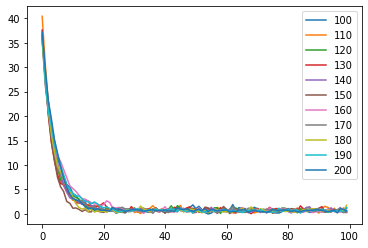

In [ ]:
print("count", "\t", "minval")
for inds in [x for x in range(100, 210, 10)]:
  minVals, avg = eaRastrigins(pop_size=inds)
  plt.plot(avg, label=inds)
  print(inds, '\t', min(minVals))

plt.legend()  
plt.show()

cxpb 	 minval
0.3 	 0.0009443094090855197
0.4 	 5.5114508136000495e-05
0.5 	 9.311999420447137e-07
0.6 	 5.561920290020339e-05
0.7 	 6.211742480388693e-06
0.8 	 0.0011513590516258887
0.9 	 6.507106675712748e-08
1.0 	 3.9678220382199925e-05


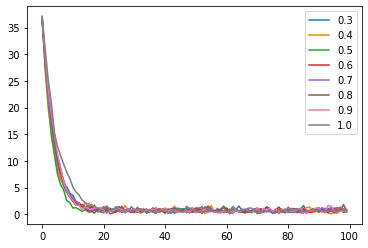

In [ ]:
print("cxpb", "\t", "minval")
for cxpb in [x*0.1 for x in range(3, 11)]:
  minVals, avg = eaRastrigins(pop_size=150, cxpb=cxpb)
  plt.plot(avg, label=round(cxpb, 1))
  print(round(cxpb, 1), '\t', min(minVals))

plt.legend()  
plt.show()

mutpb 	 minval
0.01 	 4.411196906062287e-05
0.02 	 1.8136595514306464e-07
0.03 	 2.517008815061672e-05
0.04 	 0.00011712263903973508
0.05 	 4.963008507274935e-06
0.06 	 6.383248560837274e-07
0.07 	 6.507106675712748e-08
0.08 	 6.200501445619011e-09
0.09 	 3.579822498167573e-05
0.1 	 5.514680552209938e-07


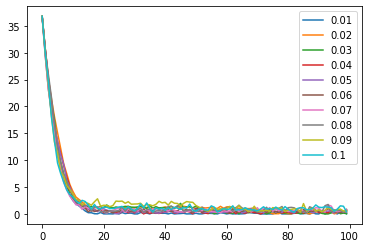

In [ ]:
print("mutpb", "\t", "minval")
for mutpb in [x*0.01 for x in range(1, 11)]:
  minVals, avg = eaRastrigins(pop_size=150, cxpb=0.9, mutpb=mutpb)
  plt.plot(avg, label=round(mutpb, 2))
  print(round(mutpb, 2), '\t', min(minVals))

plt.legend()  
plt.show()

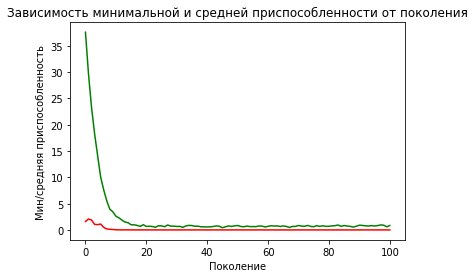

In [ ]:
plt.plot(minFitnessValues, color='red')
plt.plot(avgFitnessValues, color='green')
plt.xlabel("Поколение")
plt.ylabel('Мин/средняя приспособленность')

plt.title('Зависимость минимальной и средней приспособленности от поколения')
plt.show()

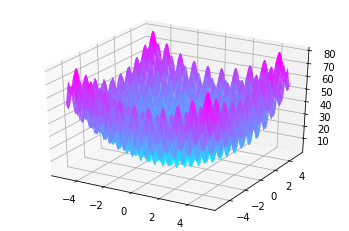

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

x, y = np.meshgrid(np.linspace(-5.12, 5.12, 500), np.linspace(-5.12, 5.12, 500))
z = f([x, y])
my_cmap = plt.get_cmap('cool')

ax.plot_surface(x, y, z, cmap=my_cmap)

plt.show()